## K-mean analysis on the most populated cities in the US

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## List with the 30 cities

In [2]:
cities = ['San Francisco, CA USA', 'Los Angeles, CA', 'San Diego, CA', 'Phoenix, AZ', 'Las Vegas, NV', 'Portland, PO',
         'Seattle, WA', 'New York City, NY', 'Chicago, IL', 'Houston, TX', 'Philadelphia, PA', 'San Antonio, TX',
         'Dallas, TX', 'San Jose, CA', 'Austin, TX', 'Boston, MA', 'Jacksonville, FL', 'Denver, CO', 'Charlotte, NC',
         'Columbus, OH', 'Fort Worth, TX', 'Indianapolis, IN', 'El Paso, TX', 'Nashville, TN', 'Detroit, MI',
        'Oklahoma City, OK', 'Memphis, TN', 'Baltimore, MD', 'Milwaukee, WI', 'Albuquerque, NM']
cities.sort()
cities

['Albuquerque, NM',
 'Austin, TX',
 'Baltimore, MD',
 'Boston, MA',
 'Charlotte, NC',
 'Chicago, IL',
 'Columbus, OH',
 'Dallas, TX',
 'Denver, CO',
 'Detroit, MI',
 'El Paso, TX',
 'Fort Worth, TX',
 'Houston, TX',
 'Indianapolis, IN',
 'Jacksonville, FL',
 'Las Vegas, NV',
 'Los Angeles, CA',
 'Memphis, TN',
 'Milwaukee, WI',
 'Nashville, TN',
 'New York City, NY',
 'Oklahoma City, OK',
 'Philadelphia, PA',
 'Phoenix, AZ',
 'Portland, PO',
 'San Antonio, TX',
 'San Diego, CA',
 'San Francisco, CA USA',
 'San Jose, CA',
 'Seattle, WA']

## Get the latitude and longitude of each city

In [3]:
columns = ['City', 'Latitude', 'Longitude']
df = pd.DataFrame(columns=columns)

for city in cities:    
    address = city
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df = df.append({'City' : city, 'Latitude' : latitude, 'Longitude' : longitude }, ignore_index=True)
    
locationUS = None    
location = geolocator.geocode(address)
latitudeUS = location.latitude
longitudeUS = location.longitude

In [4]:
df

,City,Latitude,Longitude
0,"Albuquerque, NM",35.084103,-106.650985
1,"Austin, TX",30.271129,-97.743700
2,"Baltimore, MD",39.290882,-76.610759
3,"Boston, MA",42.360253,-71.058291
4,"Charlotte, NC",35.227200,-80.843083
5,"Chicago, IL",41.875562,-87.624421
6,"Columbus, OH",39.962260,-83.000707
7,"Dallas, TX",32.776272,-96.796856
8,"Denver, CO",39.739236,-104.984862
9,"Detroit, MI",42.331551,-83.046640


## Plot a map with the cities

In [5]:
map_all_cities = folium.Map(location=[latitudeUS, longitudeUS],zoom_start=4)
# add markers to map
for lat, lng, city in zip(df['Latitude'], df['Longitude'], df['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all_cities)  
    
map_all_cities

## Colect 100 businesses per city using the FourSquare API

In [6]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [7]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 25000 # define radius

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=25000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [9]:
cities_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Albuquerque, NM
Austin, TX
Baltimore, MD
Boston, MA
Charlotte, NC
Chicago, IL
Columbus, OH
Dallas, TX
Denver, CO
Detroit, MI
El Paso, TX
Fort Worth, TX
Houston, TX
Indianapolis, IN
Jacksonville, FL
Las Vegas, NV
Los Angeles, CA
Memphis, TN
Milwaukee, WI
Nashville, TN
New York City, NY
Oklahoma City, OK
Philadelphia, PA
Phoenix, AZ
Portland, PO
San Antonio, TX
San Diego, CA
San Francisco, CA USA
San Jose, CA
Seattle, WA


In [10]:
print(cities_venues.shape)
picToReport = cities_venues.iloc[0::100,:]

(3000, 7)


In [11]:
picToReport

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Albuquerque, NM",35.084103,-106.650985,"Hotel Andaluz, Curio Collection by Hilton",35.084998,-106.649211,Hotel
100,"Austin, TX",30.271129,-97.743700,Texas State Capitol,30.274368,-97.740692,Capitol Building
200,"Baltimore, MD",39.290882,-76.610759,Baltimore Farmers' Market & Bazaar,39.293297,-76.610490,Farmers Market
300,"Boston, MA",42.360253,-71.058291,The Rose Kennedy Greenway,42.358227,-71.052055,Park
400,"Charlotte, NC",35.227200,-80.843083,Blumenthal Performing Arts Center,35.227930,-80.841951,Performing Arts Venue
500,"Chicago, IL",41.875562,-87.624421,Symphony Center (Chicago Symphony Orchestra),41.879275,-87.624680,Concert Hall
600,"Columbus, OH",39.962260,-83.000707,Ohio Theatre,39.960281,-82.999090,Theater
700,"Dallas, TX",32.776272,-96.796856,The Joule,32.780709,-96.798443,Hotel
800,"Denver, CO",39.739236,-104.984862,Denver Art Museum,39.736479,-104.988712,Art Museum
900,"Detroit, MI",42.331551,-83.046640,Campus Martius,42.331575,-83.046598,Park


In [12]:
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 284 uniques categories.


## One-Hot encoding using the business category as dummy variables.

In [13]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = cities_venues['City'] 

# move neighborhood column to the first column
first_column = cities_onehot.pop('City')
cities_onehot.insert(0, 'City', first_column)

## Group by the cities and mean of the dummies.

In [14]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped


,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bath House,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Capitol Building,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Quad,College Residence Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Distillery,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,River,Rock Club,Romanian Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Trail,Train Station,Tram Station,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Win

## Select the top 20 businesses per city

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head(30)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Albuquerque, NM",Brewery,Coffee Shop,Mexican Restaurant,Grocery Store,Park,American Restaurant,Hotel,Pizza Place,Burger Joint,BBQ Joint,Garden,Breakfast Spot,Café,Thai Restaurant,Sandwich Place,Bakery,Restaurant,Steakhouse,Ice Cream Shop,Wine Shop
1,"Austin, TX",Coffee Shop,Hotel,Pizza Place,Park,American Restaurant,Grocery Store,Seafood Restaurant,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Food Truck,Taco Place,Juice Bar,Yoga Studio,BBQ Joint,Brewery,Breakfast Spot,Pool,Bar,Trail
2,"Baltimore, MD",Seafood Restaurant,Park,Pizza Place,American Restaurant,Coffee Shop,Italian Restaurant,Bar,BBQ Joint,Art Museum,Ice Cream Shop,Bakery,Brewery,Liquor Store,Mediterranean Restaurant,Café,Bookstore,Deli / Bodega,Farmers Market,Food Court,Hotel
3,"Boston, MA",Bakery,Park,Italian Restaurant,Seafood Restaurant,Hotel,Restaurant,Brewery,Trail,Mexican Restaurant,Gastropub,American Restaurant,Gym,Sandwich Place,Pet Store,Salad Place,Pizza Place,Wine Shop,Ice Cream Shop,French Restaurant,Coffee Shop
4,"Charlotte, NC",Brewery,Pizza Place,Park,Bakery,Deli / Bodega,Bar,American Restaurant,BBQ Joint,Grocery Store,Southern / Soul Food Restaurant,Burger Joint,Gift Shop,Coffee Shop,Theater,Beer Garden,Restaurant,Sports Bar,Mexican Restaurant,Latin American Restaurant,Farmers Market
5,"Chicago, IL",Hotel,Park,Italian Restaurant,Yoga Studio,Theater,Coffee Shop,Sandwich Place,Boat or Ferry,Cocktail Bar,Mediterranean Restaurant,Seafood Restaurant,Steakhouse,Grocery Store,Burger Joint,New American Restaurant,Waterfront,Liquor Store,Tour Provider,Scenic Lookout,Flower Shop
6,"Columbus, OH",Park,Coffee Shop,American Restaurant,Brewery,Ice Cream Shop,Pizza Place,Café,Grocery Store,Bakery,Diner,Deli / Bodega,Bar,Gastropub,Breakfast Spot,Mexican Restaurant,Fried Chicken Joint,Sandwich Place,Hotel,Bistro,Camera Store
7,"Dallas, TX",Coffee Shop,Brewery,Mexican Restaurant,Seafood Restaurant,Steakhouse,Hotel,Park,Burger Joint,Taco Place,Pizza Place,Grocery Store,Bar,Trail,Gourmet Shop,New American Restaurant,Music Venue,BBQ Joint,Dessert Shop,Salon / Barbershop,Sandwich Place
8,"Denver, CO",Brewery,American Restaurant,Hotel,Coffee Shop,Italian Restaurant,Pizza Place,Breakfast Spot,Sandwich Place,Bookstore,Ice Cream Shop,Bar,New American Restaurant,French Restaurant,Grocery Store,Burger Joint,Park,Cocktail Bar,Pub,Clothing Store,Record Shop
9,"Detroit, MI",Park,Coffee Shop,American Restaurant,Brewery,Farmers Market,Hotel,Café,Steakhouse,Pizza Place,Building,Deli / Bodega,Scenic Lookout,Art Museum,Bakery,Burger Joint,Restaurant,Waterfront,Plaza,Cocktail Bar,Concert Hall


## K-means with 6 clusters

In [17]:
# set number of clusters
kclusters = 6

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:29] 

array([2, 2, 3, 3, 2, 5, 2, 2, 2, 3, 4, 4, 2, 2, 2, 5, 3, 2, 2, 2, 1, 2,
       3, 0, 2, 4, 3, 1, 4], dtype=int32)

In [18]:
# add clustering labels

cities_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

cities_merged = cities_venues_sorted.join(df.set_index('City'), on='City')


## Map with the clusters divided by colors

In [19]:
# create map
map_clusters = folium.Map(location=[latitudeUS, longitudeUS], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Bar plot of the top 10 business categories per city.

In [20]:
cluster_1 = cities_merged[cities_merged['Cluster Labels'] == 0]
cluster_2 = cities_merged[cities_merged['Cluster Labels'] == 1]
cluster_3 = cities_merged[cities_merged['Cluster Labels'] == 2]
cluster_4 = cities_merged[cities_merged['Cluster Labels'] == 3]
cluster_5 = cities_merged[cities_merged['Cluster Labels'] == 4]
cluster_6 = cities_merged[cities_merged['Cluster Labels'] == 5]

list_cluster = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]
titles = list()
for k in range(6):
    lst = list(list_cluster[k].City)
    titles.append(' '.join(lst))

In [21]:
top_20_clusters = list()
for dfs in list_cluster:
    temp_list = list()
    for col in range(2, 22):        
        for i in range(0, dfs.shape[0]):
            temp_list.append(dfs.iloc[i, col])
    top_20_clusters.append(temp_list)
    

In [22]:
from collections import Counter
df_clusters = list()
for k in range(6):
    each_cluster = Counter(top_20_clusters[k])
    temp_df = pd.DataFrame.from_dict(each_cluster, orient='index').reset_index()
    col = ['Business Category', 'Count']
    temp_df.columns = col
    temp_df.sort_values(by=['Count'], inplace=True)
    df_clusters.append(temp_df)


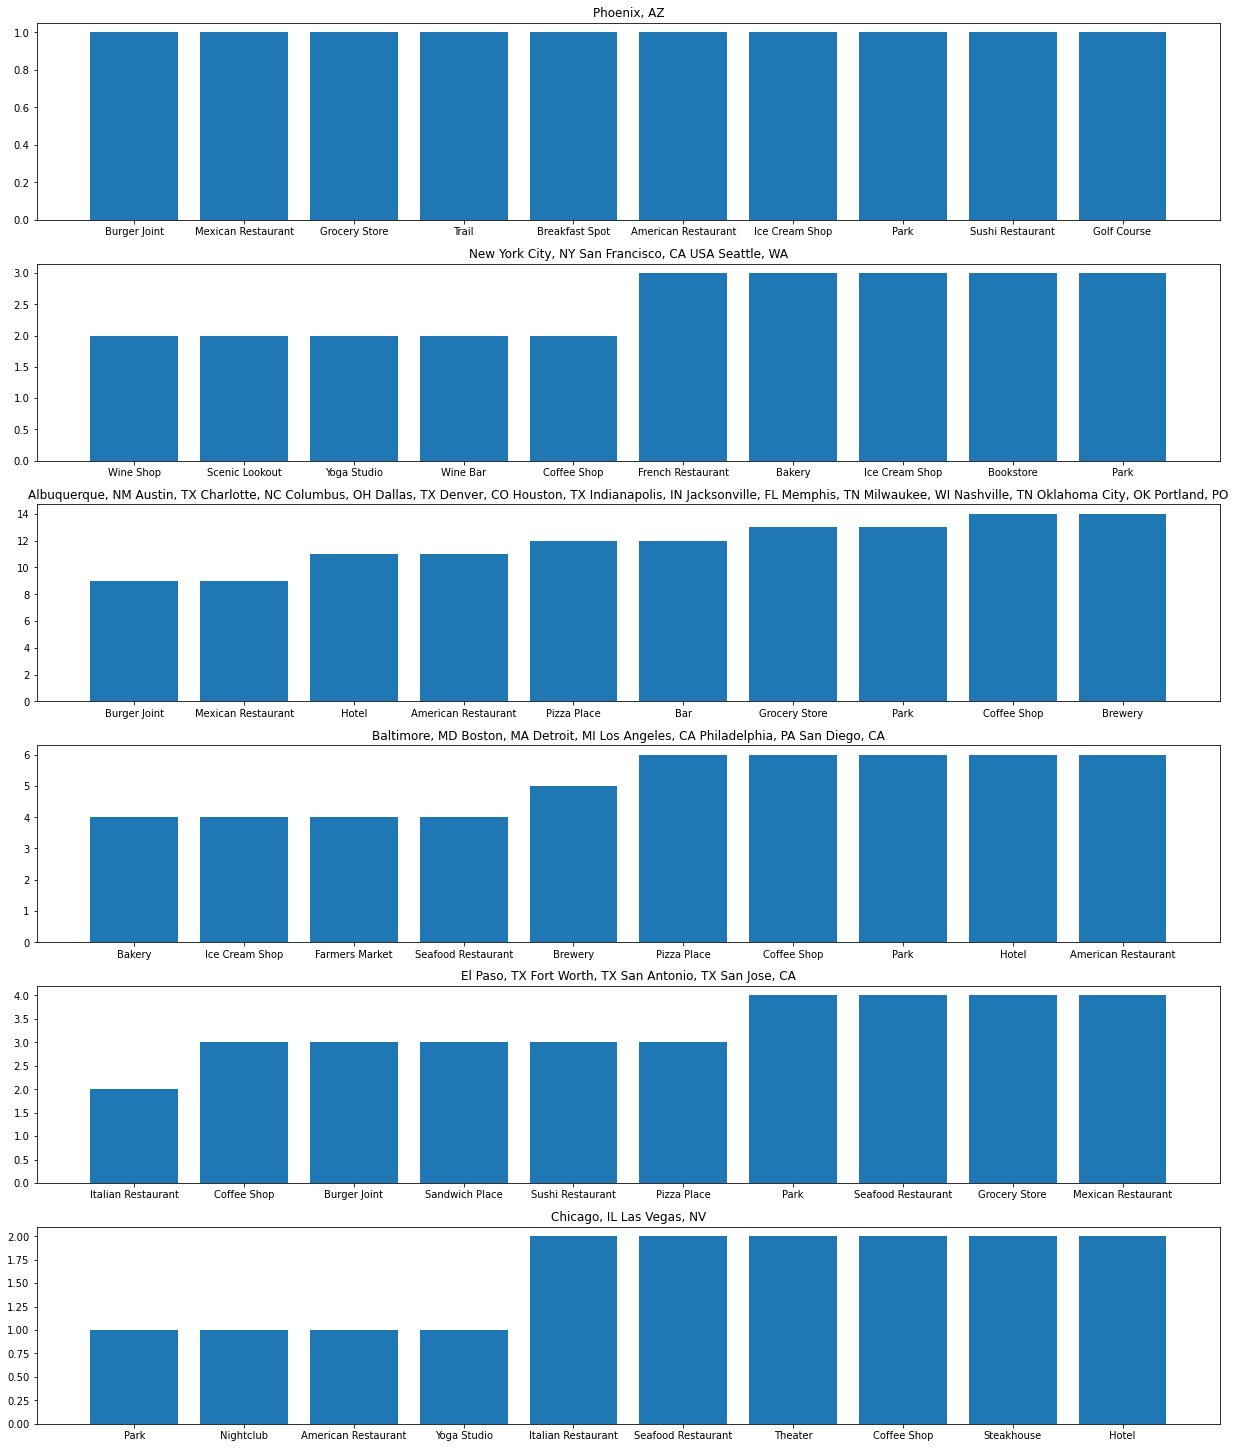

In [23]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 1, figsize=(18, 20), constrained_layout=True)
for ax, k in zip(axs, range(6)):
    ax.bar(df_clusters[k].iloc[-10:,0], df_clusters[k].iloc[-10:,1])
    ax.set_title(titles[k])